In [3]:
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")
pivoted = pd.read_parquet("/Users/tp_mini/Desktop/TS/ED/intraday/on_us/US2000_top1000.parquet")

In [37]:
code = 'CMPX'
benchmark_index = "US2000"
rolling = 5
ret = pivoted[[code, benchmark_index]].pct_change()
ret['ret_diff'] = ret[code] - ret[benchmark_index]
# type 1
# ret['ret_diff_std'] = ret['ret_diff'].rolling(rolling).std() * 100
# ret['ret_diff_mean'] = ret['ret_diff'].rolling(rolling).mean() * 100
# ret['stdize_ret_diff'] = abs((ret['ret_diff'] - ret['ret_diff_mean'])/ret['ret_diff_std'])

# type 2
ret['ret_diff_std'] = ret['ret_diff'].rolling(rolling).std()
ret['ret_diff_mean'] = ret['ret_diff'].rolling(rolling).mean()
ret['stdize_ret_diff'] = abs((ret['ret_diff'] - ret['ret_diff_mean'])*ret['ret_diff_std'])*10000

ret[code] = (1 + ret[code]).cumprod() - 1

ret['index'] = [i for i in range(len(ret))]

# check direction
ret['lag10'] = ret[code].shift(-4)
ret['change_stock'] = (ret['lag10'] - ret[code])/ret[code]

# check if the direction are the same, if not, tned to not being a mean reversion
ret['lag10_twii'] = ret[benchmark_index].shift(-4)
ret['change_twii'] = (ret['lag10_twii'] - ret[benchmark_index])/ret[benchmark_index]
ret['filter_1'] = ret.apply(lambda x: 1 if abs(x['change_stock'] - x['change_twii']) < abs(x['change_stock']) else 0, axis=1)
ret['filter_2'] = ret.apply(lambda x: 0 if abs(x['change_stock']) < abs(x['change_twii']) else 1, axis=1)

# check raise
ret[f'{code}_lag60'] = ret[code].shift(-12)
ret['stock_price'] = pivoted[code]
ret['direction'] = ret.apply(lambda x: -1 if x[code] - x['lag10'] > 0 else 1, axis=1)
ret['target_60mins'] = (np.round((ret[f'{code}_lag60'] - ret[code])/ret[code], 3)) * ret['direction']

# ret['signal_defineby_prev_ret'] = 
# specific print
ret.set_index('index', inplace=True, drop=False)
# start = -54 # -268
ret[ret['stdize_ret_diff'] >= 4].head(5)

code,CMPX,US2000,ret_diff,ret_diff_std,ret_diff_mean,stdize_ret_diff,index,lag10,change_stock,lag10_twii,change_twii,filter_1,filter_2,CMPX_lag60,stock_price,direction,target_60mins
index,,,,,,,,,,,,,,,,,
45,0.094717,-0.000389,-0.036623,0.015981,-0.009986,4.256965,45,0.103774,0.095618,0.000202,-1.519115,0,0,0.122642,1.1604,1,0.295
92,0.066038,-0.000404,-0.033784,0.018626,-0.003628,5.616897,92,0.047170,-0.285714,-0.001675,3.148655,0,0,0.066038,1.1300,-1,-0.000
156,-0.057547,0.002804,-0.098732,0.042278,-0.027642,30.054927,156,-0.067642,0.175410,0.000405,-0.855418,0,0,-0.081415,0.9990,-1,-0.415
158,-0.056604,-0.000970,0.026611,0.046465,-0.026834,24.833206,158,-0.056604,-0.000000,-0.000781,-0.194449,0,0,-0.076321,1.0000,1,0.348
160,-0.067642,0.000405,0.018461,0.049829,-0.021195,19.760351,160,-0.084906,0.255230,-0.005033,-13.414811,0,0,-0.077075,0.9883,-1,-0.139


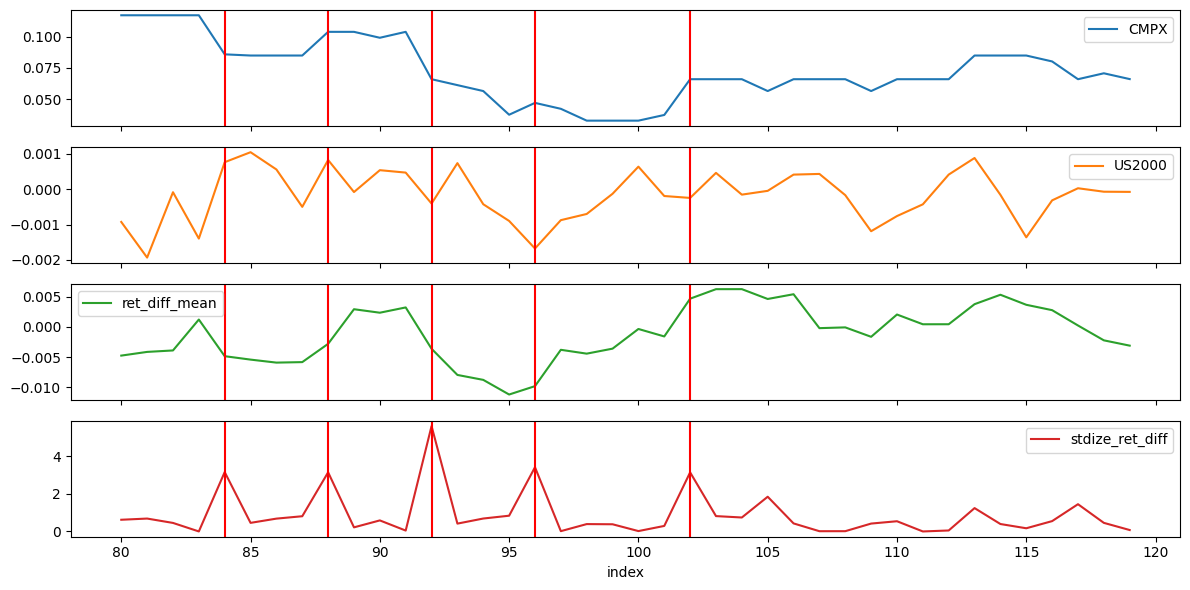

In [38]:
start = 80
end = len(ret)
end = 120
bm = 2
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 6), sharex=True)
ret.iloc[start:end, [0, 1, 4, 5]].plot(ax=axes, subplots=True, legend=True)
for index, row in ret.iloc[start:end, :][ret['stdize_ret_diff'] >= bm].iterrows():  
    for ax in axes:
        ax.axvline(row['index'], color='red')
plt.tight_layout()
plt.show()